In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import cuml
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.cluster import DBSCAN
import pandas as pd

### 1. Process data 

In [2]:
train_df = pd.read_csv("/kaggle/input/earthquake/earthquake.csv")
train_df.shape

(6291455, 2)

In [ ]:
# Read columns
ad_df = train_df['acoustic_data']
ttf_df = train_df['time_to_failure']

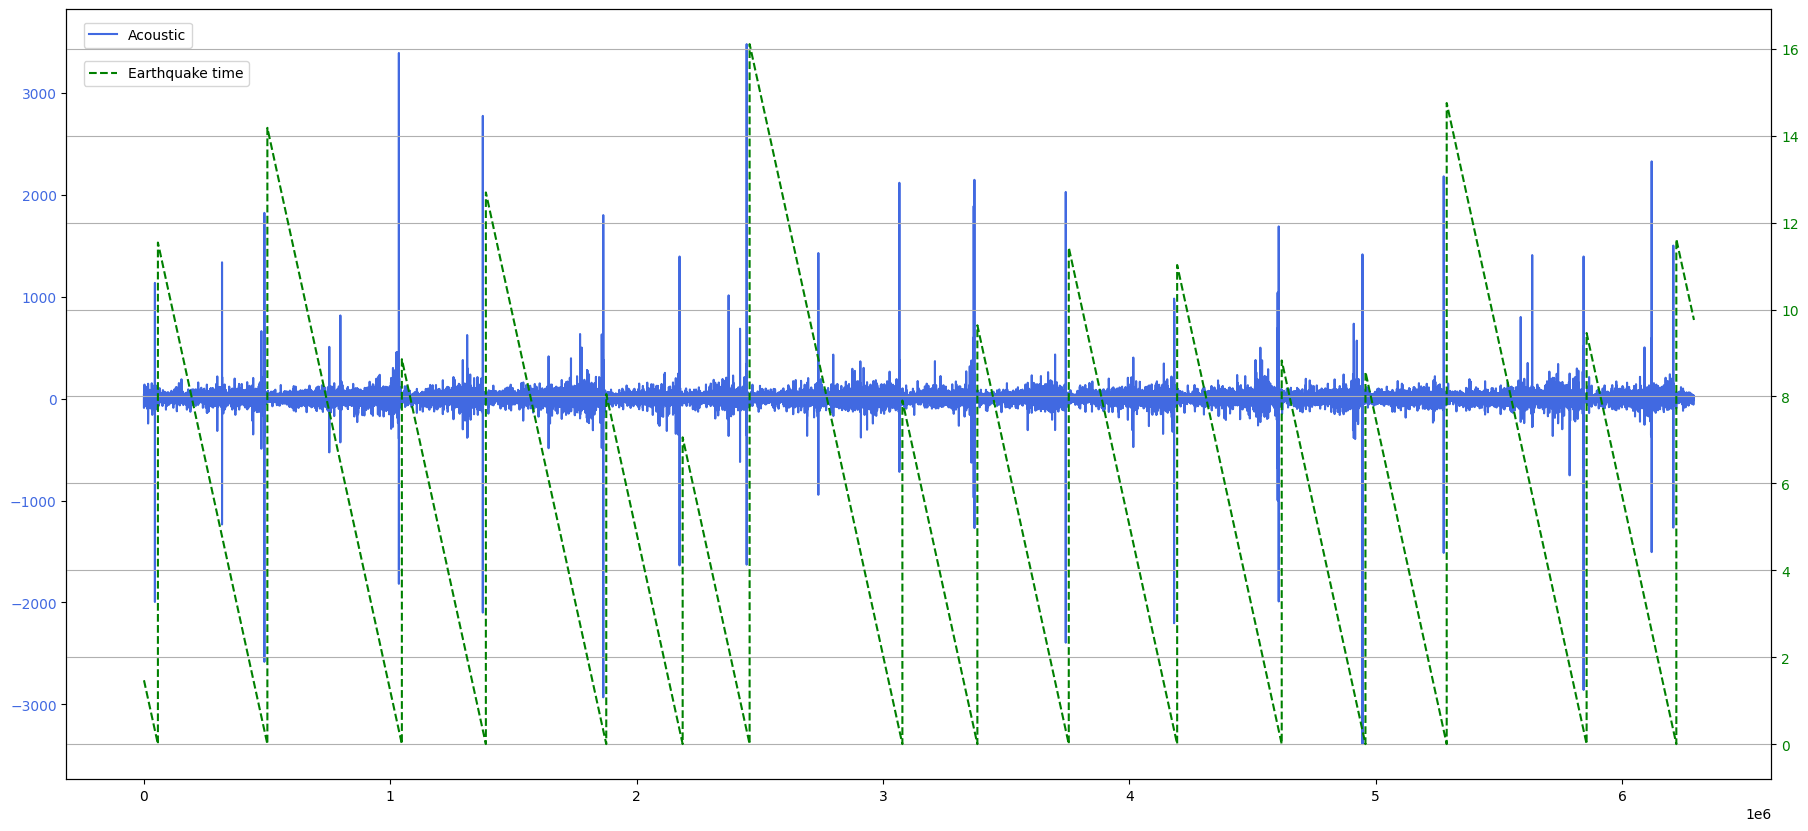

In [4]:
def plot_data(df):
    ad_df = df['acoustic_data']
    ttf_df = df['time_to_failure']
    fig, ax1 = plt.subplots(figsize=(22, 10))
    ax1.plot(ad_df, color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')
    ax1.legend(['Acoustic'], loc=(0.01, 0.95))

    ax2 = ax1.twinx()
    ax2.plot(ttf_df, color='green', linestyle='--', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(['Earthquake time'], loc=(0.01, 0.9))
    plt.grid(True)
    plt.savefig('a.jpg')
    plt.show()

plot_data(train_df)    

In [5]:
train_df.describe()

,acoustic_data,time_to_failure
count,6.291455e+06,6.291455e+06
mean,4.522284e+00,5.678292e+00
std,1.050967e+01,3.672698e+00
min,-3.389000e+03,9.552817e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173347e+00
max,3.476000e+03,1.610740e+01


### Plot with 1 chunk

In [6]:
eps = 500
min_samples = 10000
time_step = 100000

In [7]:
sample_df = train_df[:time_step]
val_sample_df = sample_df['acoustic_data'].values.reshape(-1, 1)
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(val_sample_df)
inliers = val_sample_df[dbscan_labels != -1]
outliers = val_sample_df[dbscan_labels == -1]
indices = np.where(dbscan_labels == -1)[0]

[W] [07:44:56.569617] Batch size limited by the chosen integer type (4 bytes). 25322 -> 21474. Using the larger integer type might result in better performance


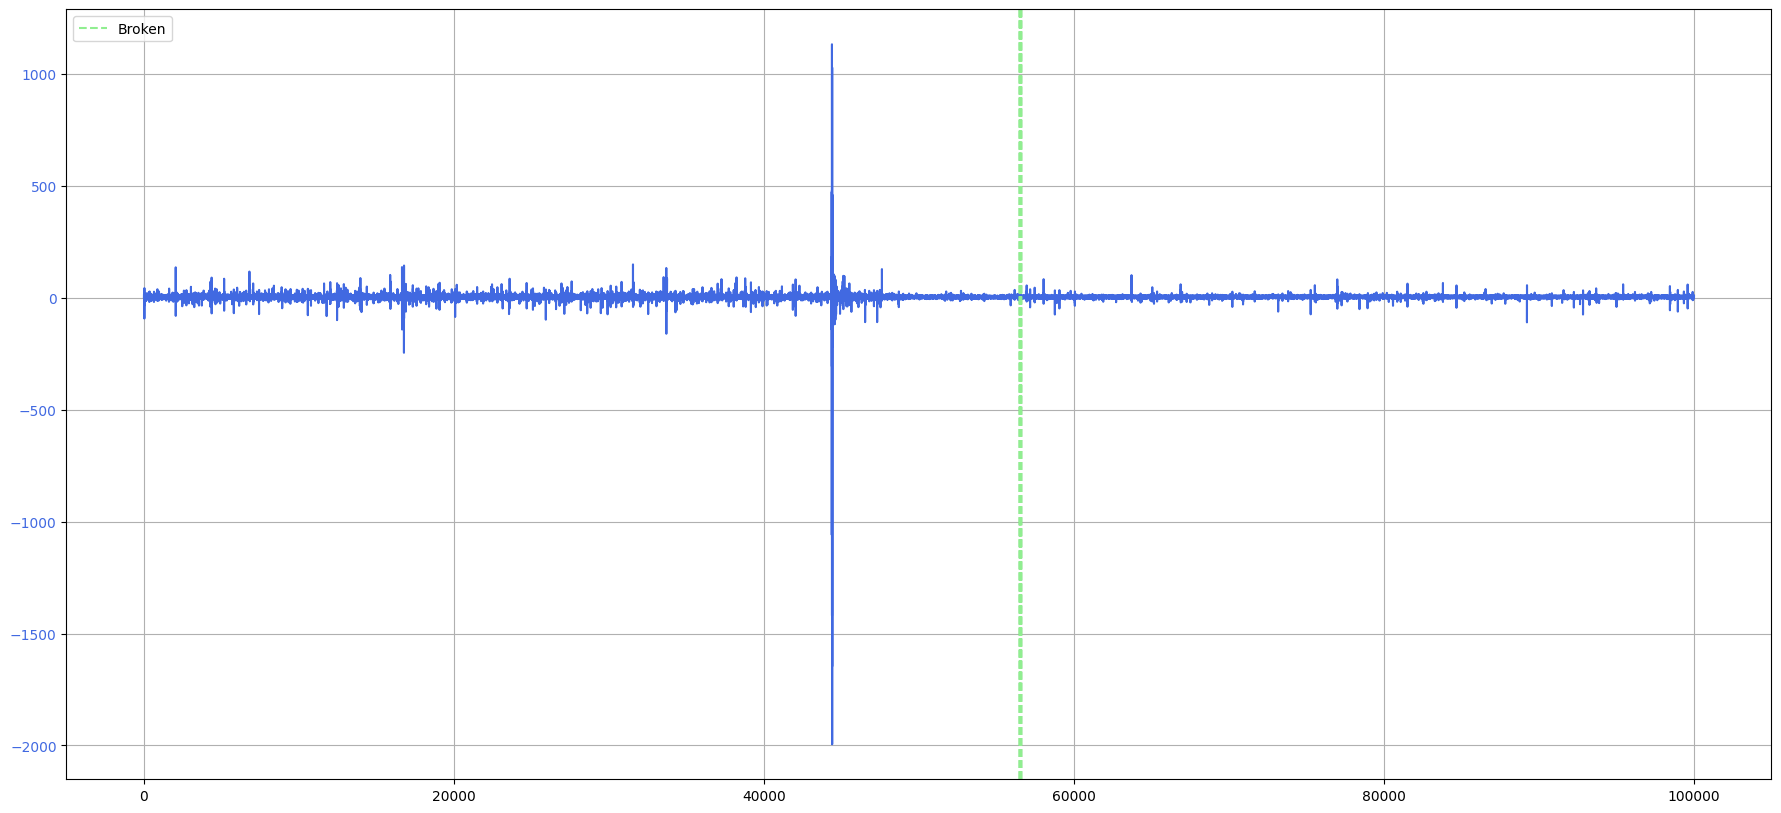

In [8]:
def single_plot(df, labels, inliers, outliers, indices):
    fig, ax1 = plt.subplots(figsize=(22, 10))
    ax1.plot(df, color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')
    ax1.legend(['Acoustic'], loc=(0.01, 0.95))
    # plt.figure(figsize=(22, 8))
    # plt.plot(df, color='royalblue')
    # plt.scatter(indices, outliers, color='red', marker='x', s=20, label='DBSCAN outliers')

    broken_points = df[(df['time_to_failure'] <= 0.001)].index
    for idx, i in enumerate(broken_points):
        ax1.axvline(x=i, color='lightgreen', linestyle='--', linewidth=1.5,
                    label='Broken' if idx == 0 else "")

    ax1.legend(loc="upper left")  # Only call plt.legend() once here
    plt.grid(True)
    plt.savefig('b.jpg')
    plt.show()

single_plot(sample_df, dbscan_labels, inliers, outliers, indices)

### Plot all data

In [9]:
# eps = 500
eps = 100
min_samples = 10000
chunk_size = 200000

In [10]:
df_chunks = train_df.copy()
df_chunks.shape

(6291455, 2)

In [11]:
lst_inliers, lst_outliers, lst_indices = [], [], []
def chunks_dbscan(df, chunk_idx):
    sample_df = df['acoustic_data'].values.reshape(-1, 1)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(sample_df)

    inliers = sample_df[dbscan_labels != -1]
    outliers = sample_df[dbscan_labels == -1]
    outlier_indices = np.where(dbscan_labels == -1)[0] + chunk_idx * chunk_size

    lst_inliers.extend(inliers)
    lst_outliers.extend(outliers)
    lst_indices.extend(outlier_indices)

In [12]:
num_chunks = len(df_chunks) // chunk_size + (1 if len(df_chunks) % chunk_size != 0 else 0)
for i in range(num_chunks):
    st_idx = i * chunk_size
    e_idx = st_idx + chunk_size
    train_chunk = df_chunks.iloc[st_idx:e_idx]
    chunks_dbscan(train_chunk, i)

[W] [07:45:01.234354] Batch size limited by the chosen integer type (4 bytes). 12659 -> 10737. Using the larger integer type might result in better performance
[W] [07:45:14.877831] Batch size limited by the chosen integer type (4 bytes). 12659 -> 10737. Using the larger integer type might result in better performance
[W] [07:45:28.778370] Batch size limited by the chosen integer type (4 bytes). 12659 -> 10737. Using the larger integer type might result in better performance
[W] [07:45:43.070968] Batch size limited by the chosen integer type (4 bytes). 12659 -> 10737. Using the larger integer type might result in better performance
[W] [07:45:56.954203] Batch size limited by the chosen integer type (4 bytes). 12659 -> 10737. Using the larger integer type might result in better performance
[W] [07:46:10.994819] Batch size limited by the chosen integer type (4 bytes). 12659 -> 10737. Using the larger integer type might result in better performance
[W] [07:46:25.402086] Batch size limited

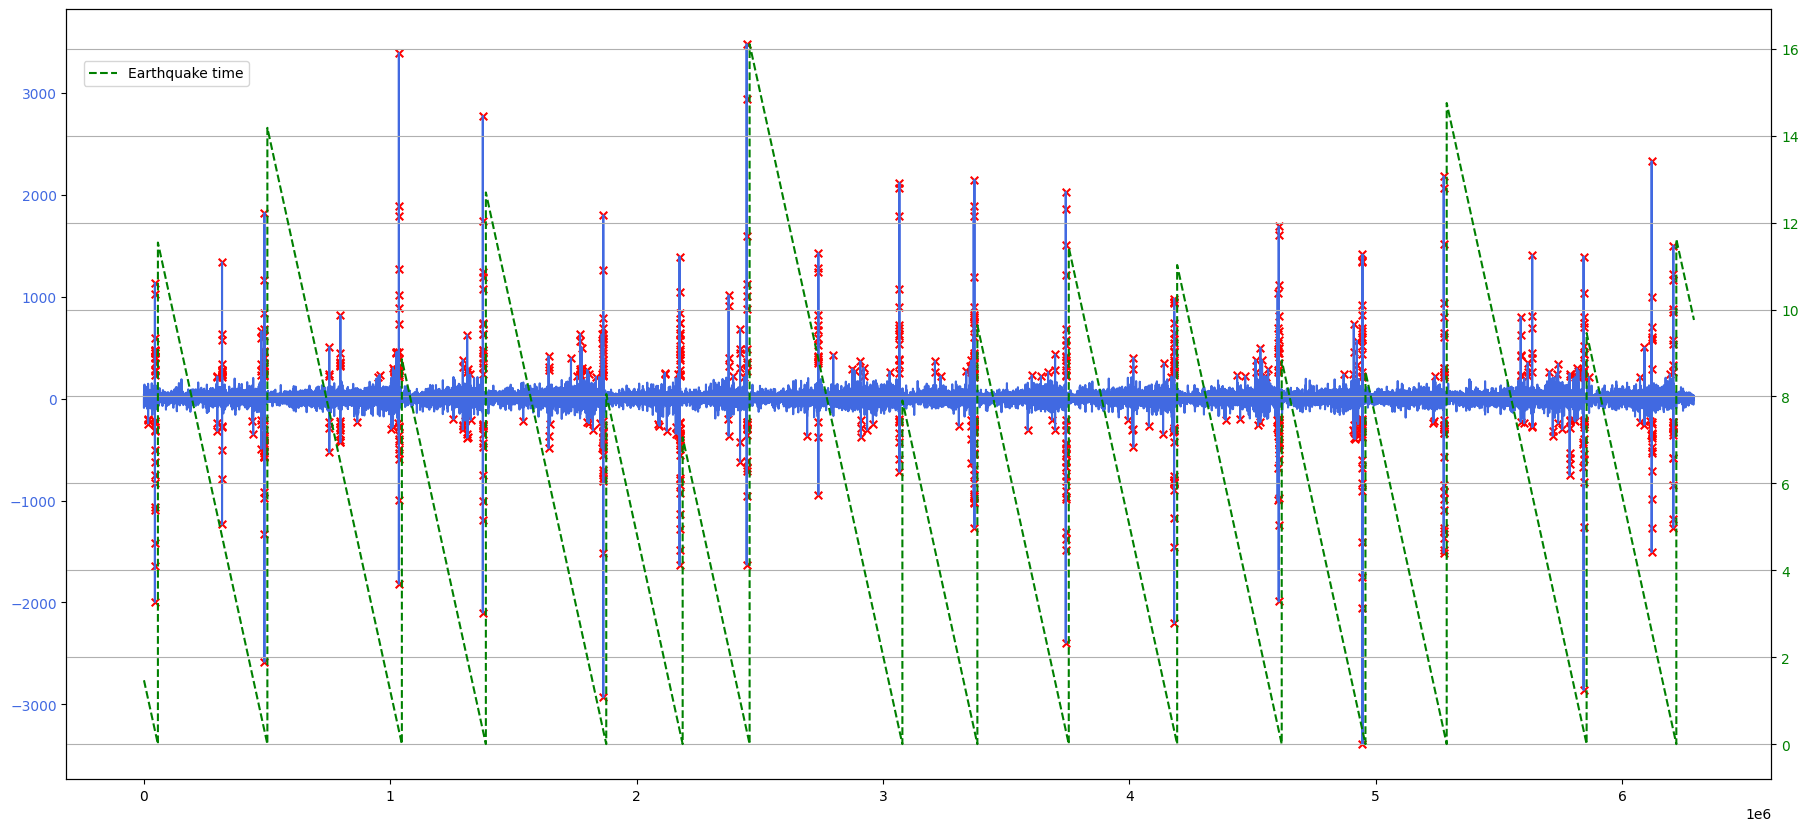

In [13]:
ad_df = df_chunks['acoustic_data']
ttf_df = df_chunks['time_to_failure']

fig, ax1 = plt.subplots(figsize=(22, 10))
ax1.plot(ad_df, color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
# ax1.legend(['Acoustic'], loc=(0.01, 0.95))
ax1.scatter(lst_indices, lst_outliers, color='red', marker='x', s=30, label='DBSCAN Outliers')

ax2 = ax1.twinx()
ax2.plot(ttf_df, color='green', linestyle='--', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(['Earthquake time'], loc=(0.01, 0.9))


plt.grid(True)
plt.savefig('c.jpg')
plt.show()